In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

<h1>Walsh function decomposition:</h1>

In [2]:
def walsh(order,x):
    res = 1
    x = np.modf(x)[0]
    x *= 2
    while order>0:
        res *= (-1)**((order%2)*np.modf(x)[1])
        order //= 2
        x = np.modf(x)[0]
        x *= 2
    return res

def walsh_coeff(f,order,M):
    sampling_points = np.linspace(0,1,num=M,endpoint=False)
    sampled_values = [walsh(order,i) for i in sampling_points]
    return np.dot(f(sampling_points),sampled_values)/M

def walsh_approximator(f,n,max_terms=1024):
    #Returns a function f^eps, the Walsh approximation of f
    # m = np.floor(np.log2(1/eps))+1
    M = int(2**n)
    # print('This is M',M)
    all_coeffs = [walsh_coeff(f,j,M) for j in range(M)]
    #Keep only largest max_terms coeffs sorted by absolute value
    largest = sorted(zip(np.abs(all_coeffs),all_coeffs,range(M)),reverse=True)[:max_terms]
    coeffs = [coeff for _,coeff,idx in largest]
    orders = [idx for _,coeff,idx in largest]
    def approximated_f(x):
        values = [walsh(j,x) for j in orders]
        return np.dot(coeffs,values)
    return approximated_f, coeffs, orders

def get_interp(amp_list):
    return interp1d(np.linspace(0,1,num=amp_list.shape[0],endpoint=False),amp_list)

In [3]:
n_qubits = 2
amp_list = np.abs(np.random.normal(0, 1, 2**n_qubits))
amp_list = amp_list/np.linalg.norm(amp_list)
f = get_interp(amp_list)

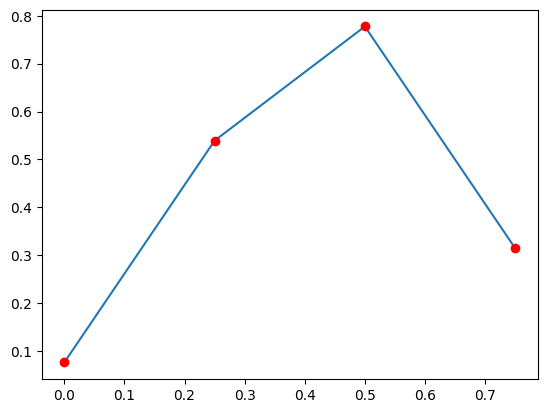

In [4]:
test_points = np.linspace(0,1,num=amp_list.shape[0],endpoint=False)
plt.scatter(np.linspace(0,1,num=amp_list.shape[0],endpoint=False),amp_list,c='red',zorder=2)
plt.plot(test_points,f(test_points),zorder=1)
plt.show()

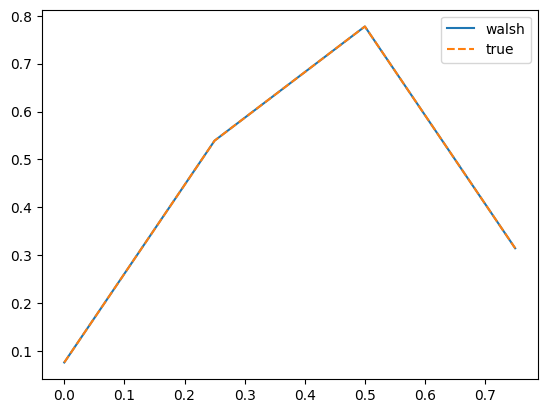

In [5]:
test_points = np.linspace(0,1,num=amp_list.shape[0],endpoint=False)
approx_f, coeffs, orders = walsh_approximator(f,n_qubits)
sampled_points = np.array([approx_f(i) for i in test_points])
plt.plot(test_points,sampled_points,label='walsh')
plt.plot(test_points,f(test_points),label='true',linestyle='--')
plt.legend()
plt.show()

<h1>Walsh state preparation:</h1>

In [34]:
def walsh_operator(wires,ancilla,coeff,eps0):
    for q in wires[:-1]:
        qml.Toffoli([ancilla[0],q,wires[-1]])
    qml.CRZ(-2*coeff*eps0,wires=[ancilla[0],wires[-1]])
    for q in reversed(wires[:-1]):
        qml.Toffoli([ancilla[0],q,wires[-1]])

def walsh_unitary(f,wires,ancilla,eps0,k,max_terms):
    approx_f,coeffs,orders = walsh_approximator(f,k,max_terms)
    for coeff,order in zip(coeffs,orders):
        bin_ord = list(np.binary_repr(order,width=len(wires)))
        bin_ord.reverse()
        bin_ord = np.array(bin_ord)
        indices = np.where(bin_ord == '1')
        on_wires = np.take_along_axis(np.array(wires),indices[0],0)
        if order>0:
            walsh_operator(on_wires,ancilla,coeff,eps0)
    return np.array(coeffs)[np.nonzero(np.array(orders)==0)]

def walsh_state_prep(wires,ancilla,f,eps0,k,max_terms):
    for wire in wires:
        qml.Hadamard(wire)
    qml.Hadamard(ancilla[0])
    zero_coeff = walsh_unitary(f,wires,ancilla,eps0,k,max_terms)
    if zero_coeff.size > 0:
        qml.RZ(1*zero_coeff[0]*eps0,wires=ancilla[0])
    qml.Hadamard(ancilla[0])
    qml.adjoint(qml.S)(ancilla[0])

In [10]:
num_qubits = 5
amp_list = np.abs(np.random.normal(0,1,2**num_qubits))
amp_list = amp_list/np.linalg.norm(amp_list)

In [35]:
dev = qml.device('default.qubit',wires=num_qubits+1)

@qml.qnode(dev)
def circuit(wires,ancilla,f,eps0,k,max_terms=1024):
    walsh_state_prep(wires,ancilla,f,eps0,k,max_terms)
    return qml.state()

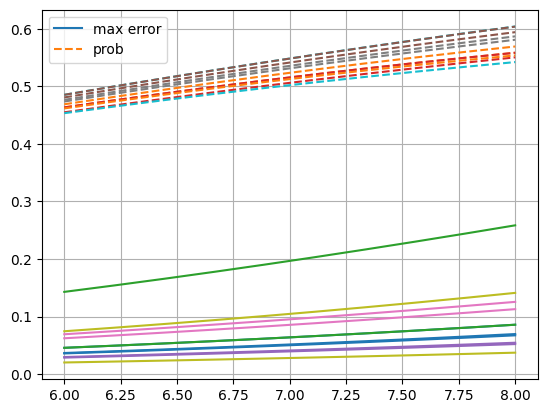

In [12]:
for i in range(10):
    amp_list = np.abs(np.random.normal(0,1,2**num_qubits))
    amp_list = amp_list/np.linalg.norm(amp_list)
    max_error = []
    prob = []
    samples = np.linspace(6,8,num=10)
    sample_points = np.linspace(0,1,num=2**num_qubits,endpoint=False)
    for e in samples:
        res = circuit(np.array(range(1,num_qubits+1)),np.array([0]),get_interp(amp_list),e,num_qubits)
        res_p = res[res.shape[0]//2:]
        prob.append(np.linalg.norm(res_p))
        res_pn = np.abs(res_p)/np.linalg.norm(res_p)
        max_error.append(np.max(np.abs(res_pn-get_interp(amp_list)(sample_points))))
    if i==0:
        plt.plot(samples,max_error,label='max error')
        plt.plot(samples,prob,linestyle='--',label='prob')      
    plt.plot(samples,max_error)
    plt.plot(samples,prob,linestyle='--')
plt.legend()
plt.grid()
plt.show()

In [36]:
res = circuit(np.array(range(1,num_qubits+1)),np.array([0]),get_interp(amp_list),6.5,num_qubits)

0.48827666858295254
[0.16417535 0.07132668 0.20083235 0.20951088 0.04064854 0.12064296
 0.03323858 0.0705219  0.06524963 0.34148426 0.12896461 0.31134985
 0.06048665 0.26298199 0.09841965 0.34513811 0.0344255  0.3291985
 0.22473255 0.16473106 0.14148214 0.13631184 0.05894519 0.23023695
 0.0258517  0.31790923 0.04748125 0.00250677 0.16057737 0.09317417
 0.02312129 0.06406926]


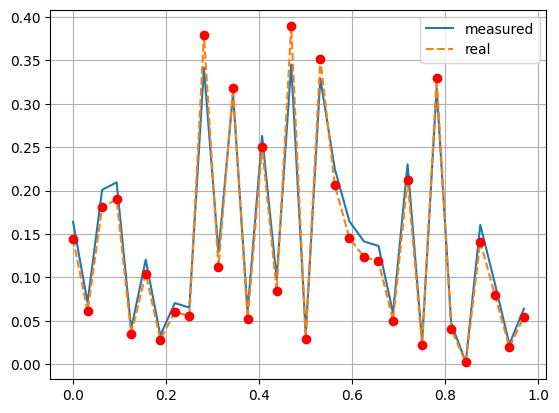

In [37]:
res_p = res[res.shape[0]//2:]
print(np.linalg.norm(res_p))
res_pn = np.abs(res_p)/np.linalg.norm(res_p)
sample_points = np.linspace(0,1,num=2**num_qubits,endpoint=False)
print(res_pn)
plt.plot(sample_points,res_pn,label='measured')
plt.plot(sample_points,get_interp(amp_list)(sample_points),label='real',linestyle='--')
plt.scatter(sample_points,amp_list,c='red',zorder=2)
plt.legend()
plt.grid()
plt.show()

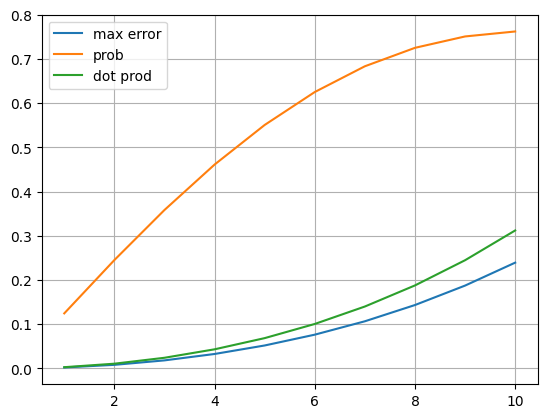

In [283]:
max_error = []
prob = []
dot_prod = []
samples = np.linspace(1,6,num=6)
sample_points = np.linspace(0,1,num=2**num_qubits,endpoint=False)
for e in samples:
    res = circuit(np.array(range(1,num_qubits+1)),np.array([0]),get_interp(amp_list),e,num_qubits)
    res_p = res[res.shape[0]//2:]
    prob.append(np.linalg.norm(res_p))
    res_pn = np.abs(res_p)/np.linalg.norm(res_p)
    max_error.append(np.max(np.abs(res_pn-get_interp(amp_list)(sample_points))))
    dot_prod.append(np.arccos(np.dot(res_pn,amp_list)))
plt.plot(samples,max_error,label='max error')
plt.plot(samples,prob,label='prob')
plt.plot(samples,dot_prod,label='dot prod')
plt.legend()
plt.grid()
plt.show()

<h1>Running circuits on IBMQ:</h1>

In [7]:
from qiskit_ibm_provider import IBMProvider

In [8]:
provider = IBMProvider()

In [22]:
num_qubits = 5
real_device = qml.device('qiskit.ibmq', wires=num_qubits+1, backend='ibmq_qasm_simulator', shots=1000, provider=provider)

In [23]:
real_device.capabilities()

{'model': 'qubit',
 'tensor_observables': True,
 'inverse_operations': True,
 'returns_state': False,
 'supports_broadcasting': False,
 'supports_finite_shots': True,
 'supports_tensor_observables': True,
 'returns_probs': True}

In [38]:
@qml.qnode(real_device)
def real_circuit(wires,ancilla,f,eps0,k,max_terms=1024):
    walsh_state_prep(wires,ancilla,f,eps0,k,max_terms)
    return qml.counts()

In [39]:
res = real_circuit(np.array(range(1,num_qubits+1)),np.array([0]),get_interp(amp_list),6.5,num_qubits)

In [40]:
print(res)

{'000000': 25, '000001': 26, '000010': 18, '000011': 24, '000100': 30, '000101': 32, '000110': 36, '000111': 18, '001000': 42, '001001': 3, '001010': 25, '001011': 5, '001100': 31, '001101': 14, '001110': 25, '001111': 4, '010000': 25, '010001': 10, '010010': 18, '010011': 35, '010100': 21, '010101': 35, '010110': 36, '010111': 18, '011000': 42, '011001': 7, '011010': 21, '011011': 35, '011100': 16, '011101': 29, '011110': 33, '011111': 27, '100000': 7, '100001': 1, '100010': 7, '100011': 5, '100101': 6, '100111': 2, '101000': 1, '101001': 30, '101010': 4, '101011': 16, '101101': 17, '101110': 1, '101111': 35, '110000': 1, '110001': 12, '110010': 11, '110011': 10, '110100': 6, '110101': 5, '110110': 2, '110111': 9, '111001': 39, '111010': 1, '111100': 4, '111101': 1, '111111': 1}


In [45]:
sum=0
for key,val in res.items():
    if key[-1]=='1':
        sum+=val
print(sum)

511


In [ ]:
res_p = res[res.shape[0]//2:]
print(np.linalg.norm(res_p))
res_pn = np.abs(res_p)/np.linalg.norm(res_p)
sample_points = np.linspace(0,1,num=2**num_qubits,endpoint=False)
print(res_pn)
plt.plot(sample_points,res_pn,label='measured')
plt.plot(sample_points,get_interp(amp_list)(sample_points),label='real',linestyle='--')
plt.scatter(sample_points,amp_list,c='red',zorder=2)
plt.legend()
plt.grid()
plt.show()